In [1]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Conv1D, MaxPooling1D,Flatten,MultiHeadAttention, LayerNormalization,Reshape,Input
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.losses import Huber
import warnings
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import random
import logging
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")


In [2]:
numa_warning_filter = logging.Filter('could not open file to read NUMA node')
tf.get_logger().addFilter(numa_warning_filter)

In [3]:
SEED = 42
# Set the seed for Python's random module
random.seed(SEED)
# Set the seed for NumPy
np.random.seed(SEED)
# Set the seed for TensorFlow
tf.random.set_seed(SEED)

# **Loading Dataset**

In [4]:
# Load the data
train_df = pd.read_csv("Traning_dataset.csv",index_col="Unnamed: 0")
test_df = pd.read_csv("testing_dataset.csv",index_col="Unnamed: 0")
test_surplus = pd.read_csv("Test_Surplus_energy.csv")
train_surplus = pd.read_csv("Train_Surplus_energy.csv")
train_df.head()

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,Day,Month,Year,DayOfYear,WeekOfYear
2010-01-01 00:00:00,1.9,-0.5,84.25,0.417,100.0,0.0,0.0,19.4,11.0,999.9,62.2,0.0,0.0,0.0,1,1,2010,1,53
2010-01-01 01:00:00,1.9,-0.5,83.90,0.000,0.0,0.0,0.0,21.8,19.0,999.8,22.4,0.0,0.0,0.0,1,1,2010,1,53
2010-01-01 02:00:00,1.4,-0.7,85.76,0.000,0.0,0.0,0.0,17.7,10.0,1000.0,38.0,0.0,0.0,0.0,1,1,2010,1,53
2010-01-01 03:00:00,1.4,-0.7,85.69,0.000,0.0,0.0,0.0,18.0,11.0,1000.2,66.7,0.0,0.0,0.0,1,1,2010,1,53
2010-01-01 04:00:00,1.3,-0.8,85.72,0.000,0.0,0.0,0.0,17.4,10.0,1000.5,62.8,0.0,0.0,0.0,1,1,2010,1,53


# **Data Preprocessing**

**Data Splitting** 
- It's crucial to split the training data into two subsets: a training set (typically 80% of the data) and a validation set (the remaining 20%). This  helps asses the model's performance and prevents overfitting.

In [5]:
train_df

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,Day,Month,Year,DayOfYear,WeekOfYear
2010-01-01 00:00:00,1.9,-0.5,84.25,0.417,100.0,0.0,0.0,19.4,11.0,999.9,62.2,0.0,0.0,0.0,1,1,2010,1,53
2010-01-01 01:00:00,1.9,-0.5,83.90,0.000,0.0,0.0,0.0,21.8,19.0,999.8,22.4,0.0,0.0,0.0,1,1,2010,1,53
2010-01-01 02:00:00,1.4,-0.7,85.76,0.000,0.0,0.0,0.0,17.7,10.0,1000.0,38.0,0.0,0.0,0.0,1,1,2010,1,53
2010-01-01 03:00:00,1.4,-0.7,85.69,0.000,0.0,0.0,0.0,18.0,11.0,1000.2,66.7,0.0,0.0,0.0,1,1,2010,1,53
2010-01-01 04:00:00,1.3,-0.8,85.72,0.000,0.0,0.0,0.0,17.4,10.0,1000.5,62.8,0.0,0.0,0.0,1,1,2010,1,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-18 14:00:00,8.6,5.0,78.18,0.000,0.0,0.0,0.0,14.7,13.0,1027.9,78.8,227.0,0.8,2.0,18,3,2021,77,11
2021-03-18 15:00:00,8.8,4.5,74.46,0.000,0.0,0.0,0.0,13.0,353.0,1027.3,86.8,141.0,0.5,1.0,18,3,2021,77,11
2021-03-18 16:00:00,8.8,4.7,75.45,0.000,0.0,0.0,0.0,18.1,352.0,1026.7,80.2,128.0,0.5,1.0,18,3,2021,77,11
2021-03-18 17:00:00,8.5,5.2,79.95,0.000,0.0,0.0,0.0,13.3,350.0,1026.2,90.5,55.0,0.2,1.0,18,3,2021,77,11


In [6]:
# Splitting the data to train and validation
X_train, X_val, y_train, y_val = train_test_split(train_df,train_df[['windspeed',"solarenergy"]],test_size=0.2,shuffle=False)
# Splitting the data to train and validation
X_train_surplus, X_val_surplus = train_test_split(train_surplus, test_size=0.2, shuffle=False)

**Data Normalisation**
- Since the data contain features with different scales which might effect the model resulting a biased model. Therefore data will be normalised

**Note: To maintain data integrity and prevent any data leakage, the splitting of the data into training and validation/test sets was performed before normalization.**


In [7]:
# Normalize the training and validation features using MinMaxScaler
features_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
# Scale the training features
X_train_scaled = features_scaler.fit_transform(X_train)
# Scale the validation and testing features using the same scaler trained on the training data
X_val_scaled = features_scaler.transform(X_val)
X_test_scaled = features_scaler.transform(test_df)

# Scale the training target variables
y_train_scaled = target_scaler.fit_transform(y_train)
# Scale the validation and testing target variables using the same scaler trained on the training data
y_val_scaled = target_scaler.transform(y_val)
y_test_scaled = target_scaler.transform(test_df[['windspeed', "solarenergy"]])

In [8]:
# Create a time series dataset for training data
train_data = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train_scaled[: ],
    y_train_scaled[47:],
    sequence_length=24,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None
)
# Create a time series dataset for validation data
valid_data = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_val_scaled[:],
    y_val_scaled[47:],
    sequence_length=24,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None
)
# Create a time series dataset for testing data
test_data= tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test_scaled[:],
    y_test_scaled[47:],
    sequence_length=24,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None
)


# **Modelling**

**In this section**, 
- different models will be trained, including mean, LSTM, CNN, and CNN+LSTM. The best-performing model among them will be chosen.
- Various evaluation metrics will be employed to assess the performance. For predicting Solar Energy and Wind Speed, the Mean Squared Error (MSE) metric will be utilized.
-  for the surplus of Power, metrics such as Accuracy, Precision, Recall, and False Positive Rate will be employed to evaluate the model's performance comprehensively.

In [9]:
class Model_Evaluation:
    """
    This class, Model_Evaluation, is designed to evaluate the performance of the trained models,
    particularly in the context of predicting energy surplus. It provides methods for various evaluation
    metrics, plotting, and analysis related to the model's predictions.
    """
    def __init__(self):
        # Define constants for calculations
        self.acre_to_m2 = 4046.856422
        self.MJ_to_GWH = 2.77777778 * (10**(-7))
        self.Area = 125
        self.khp_to_meter_per_second = 0.277777778
        self.GW_to_GWH = 8760
        self.W_to_Gw = 10**(-9)
        self.A = 2.11
        self.rho = 1.225
        self.number_of_turbine = 50

    def Calculation(self, prediction, test_data, df, sequence_length):
        # Make predictions using the model
        
        prediction = pd.DataFrame(target_scaler.inverse_transform(prediction), columns=['windspeed', "solarenergy"])

        # Calculate Solar Power GwH
        prediction["Solar Power GwH"] = (prediction["solarenergy"]) * self.Area * self.acre_to_m2 * self.MJ_to_GWH

        # Calculate Wind Power GWH
        prediction["Wind Power GWH"] = 0.5 * (self.rho) * (self.A) * ((prediction["windspeed"]*self.khp_to_meter_per_second)**3) * (self.W_to_Gw) * (self.GW_to_GWH) * (self.number_of_turbine)

        # Calculate Total Generated Power (GWH)
        prediction["Total Generated Power(GWH)"] = prediction["Solar Power GwH"] + prediction["Wind Power GWH"]

        # Add Month column
        prediction["Month"] = df[24+sequence_length-1:]["Month"].values

        # Calculate hourly power consumption based on month
        prediction['hourly_power_consumption'] = np.where(((prediction['Month'] == 1) | (prediction['Month'] == 2) | (prediction['Month'] == 3) |
                                                            (prediction['Month'] == 10) | (prediction['Month'] == 11) | (prediction['Month'] == 12)),
                                                           0.24,  # For months January, February, March, October, November, December
                                                           0.16   # For other months
                                                          )

        # Calculate Power difference
        prediction["Power difference"] = prediction["Total Generated Power(GWH)"] - prediction["hourly_power_consumption"]

        # Create a new column to indicate surplus of energy (True - False)
        prediction["surplus_of_energy"] = prediction['Power difference'] > 0
        
        prediction.replace({True: 1, False: 0}, inplace=True)

        return prediction
    def False_Positive_Dates(self,prediction,surplus,df):
        Dates = []
        for index,i in enumerate(zip(prediction["surplus_of_energy"],surplus)):
            if (i[0] == 1) and (i[1]==0):
                Dates.append(df[24+24-1:].iloc[index].name)
        
        Dates = pd.DataFrame(Dates,columns=["Dates"])
        return Dates
        
                
    def Evaluation(self, model, test_data, df, surplus, sequence_length):
        prediction = model.predict(test_data)
        prediction = self.Calculation(prediction, test_data, df, sequence_length)
       
        #in Case if you want to see the prediction, just uncomment this line
        #print(Prediction)
        
        Mse = model.evaluate(test_data)

        surplus.replace({True: 1, False: 0}, inplace=True)

        # Calculate accuracy
        accuracy = (prediction["surplus_of_energy"] == surplus["surplus_of_energy"][24+sequence_length-1:].values).mean()

        # Calculate precision
        precision = precision_score(surplus["surplus_of_energy"][24+sequence_length-1:].values, prediction["surplus_of_energy"])

        # Calculate recall
        recall = recall_score(surplus["surplus_of_energy"][24+sequence_length-1:].values, prediction["surplus_of_energy"])

        # Calculate confusion matrix and False Positive Rate
        cm = confusion_matrix(surplus["surplus_of_energy"][24+sequence_length-1:].values, prediction["surplus_of_energy"])
        FP = cm[0, 1]  # False positives are in the first row, second column
        FPR = FP / (FP + cm[0, 0])  # False positives / (False positives + True negatives)
        
        False_Positive_Days = self.False_Positive_Dates(prediction,surplus["surplus_of_energy"][24+sequence_length-1:],df)

        # Create a DataFrame to store the evaluation metrics
        results_df = pd.DataFrame({
            'Metric': ["MSE", 'Accuracy', 'Precision', 'Recall', 'False Positive Rate'],
            'Value': [Mse[1], accuracy, precision, recall, FPR]
        })

        return results_df,False_Positive_Days
    
    def Plot(self,History):
        plt.plot(History.history['loss'], label='Training Loss')
        plt.plot(History.history['val_loss'], label='Validation Loss')
        # Add labels and legend
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        # Show plot
        plt.show()
    
    def Full_Evaluation(self,Training,Validation,Testing):
        combined_df = pd.concat([Training, Validation, Testing], axis=1)
        combined_df.columns = ['Training', combined_df.columns[1], 'Validation', combined_df.columns[3], 'Testing', combined_df.columns[5]]
        print(combined_df)
        return combined_df
    def False_Positive_Rate_Anaylsis(self,Dates,model_name):
    
        Dates["Dates"] = pd.to_datetime(Dates["Dates"])
        # Extract day, month, year, and hour
        Dates['day'] = Dates['Dates'].dt.day
        Dates['month'] = Dates['Dates'].dt.month
        Dates['year'] = Dates['Dates'].dt.year
        Dates['hour'] = Dates['Dates'].dt.hour
         
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.bar(Dates['day'].value_counts().index, Dates['day'].value_counts().values)
        plt.xlabel("Days")
        plt.ylabel("False Positive Count")
        
        plt.subplot(2, 2, 2)  
        plt.bar(Dates['month'].value_counts().index, Dates['month'].value_counts().values)
        plt.xlabel("month")
        plt.ylabel("False Positive Count")
        
        plt.subplot(2, 2, 3)
        plt.bar(Dates['year'].value_counts().index, Dates['year'].value_counts().values)
        plt.xlabel("year")
        plt.ylabel("False Positive Count")
        # Subplot 4: Accuracy
        plt.subplot(2, 2, 4)
        plt.bar(Dates['hour'].value_counts().index, Dates['hour'].value_counts().values)
        plt.xlabel("hour")
        plt.ylabel("False Positive Count")
        
        plt.suptitle("False Positive Rate Analysis - " + model_name)
        plt.tight_layout()  
        plt.show()
        
        print("Top 3 most frequent days:", Dates['day'].value_counts().index[:3].tolist())
        print("Top 3 most frequent months:", Dates['month'].value_counts().index[:3].tolist())
        print("Top 3 most frequent years:", Dates['year'].value_counts().index[:3].tolist())
        print("Top 3 most frequent hours:", Dates['hour'].value_counts().index[:3].tolist())
        

**Base Model**

In [10]:
actual=y_test_scaled[47:]
# Calculate the mean of the target variable from the training set
mean_target_train = np.mean(y_train_scaled, axis=0)
# Use the mean from the training set to predict the target variable for the test set
mean_predictions_test = np.full_like(actual, mean_target_train)

# Calculate the Mean Squared Error (MSE) for the mean model
mean_mse_test = np.mean((actual - mean_predictions_test) ** 2)
print("Mean Squared Error (MSE) for Mean Model (using mean from training set):", mean_mse_test)

Mean Squared Error (MSE) for Mean Model (using mean from training set): 0.032014024317623735


**LSTM Model Training and Evaluation**

In [11]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(units=32))
model.add(Dense(units=16,activation="relu"))
model.add(Dense(units=2))
# Early stopping of the model before overfitting and restore the best weights
callback = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
# Compile the model
model.compile(optimizer='adam', loss=Huber(),metrics=["mse"])

# Train the model
History=model.fit(train_data,validation_data=valid_data,epochs=50,callbacks=[callback])

Epoch 1/50
614/614 [==============================] - 13s 16ms/step - loss: 0.0080 - mse: 0.0159 - val_loss: 0.0083 - val_mse: 0.0165
Epoch 2/50
614/614 [==============================] - 9s 15ms/step - loss: 0.0067 - mse: 0.0134 - val_loss: 0.0075 - val_mse: 0.0150
Epoch 3/50
614/614 [==============================] - 9s 14ms/step - loss: 0.0065 - mse: 0.0130 - val_loss: 0.0071 - val_mse: 0.0142
Epoch 4/50
614/614 [==============================] - 9s 14ms/step - loss: 0.0063 - mse: 0.0126 - val_loss: 0.0068 - val_mse: 0.0137
Epoch 5/50
614/614 [==============================] - 9s 14ms/step - loss: 0.0061 - mse: 0.0122 - val_loss: 0.0069 - val_mse: 0.0137
Epoch 6/50
614/614 [==============================] - 9s 14ms/step - loss: 0.0060 - mse: 0.0120 - val_loss: 0.0070 - val_mse: 0.0140
Epoch 7/50
614/614 [==============================] - 9s 14ms/step - loss: 0.0059 - mse: 0.0119 - val_loss: 0.0076 - val_mse: 0.0152


In [12]:
# Instantiate the Model_Evaluation class
Eval = Model_Evaluation()
# Perform evaluation on training data and get False Positive Rate Dates
Training,M_FPRD_training=Eval.Evaluation(model,train_data,X_train,X_train_surplus,24)
# Perform evaluation on validation data and get False Positive Rate Dates
Validation,M_FPRD_validation=Eval.Evaluation(model,valid_data,X_val,X_val_surplus,24)
# Perform evaluation on test data and get False Positive Rate Dates
Testing,M_FPRD_testing=Eval.Evaluation(model,test_data,test_df,test_surplus,24)
# Combine the evaluation results from training, validation, and testing
model_evaluation=Eval.Full_Evaluation(Training,Validation,Testing)

192/192 [==============================] - 2s 8ms/step - loss: 0.0068 - mse: 0.0136
              Training     Value           Validation     Value  \
0                  MSE  0.012845                  MSE  0.013651   
1             Accuracy  0.841790             Accuracy  0.826652   
2            Precision  0.857210            Precision  0.812207   
3               Recall  0.629047               Recall  0.571051   
4  False Positive Rate  0.052209  False Positive Rate  0.059045   

               Testing     Value  
0                  MSE  0.013642  
1             Accuracy  0.840470  
2            Precision  0.774245  
3               Recall  0.658024  
4  False Positive Rate  0.081773  


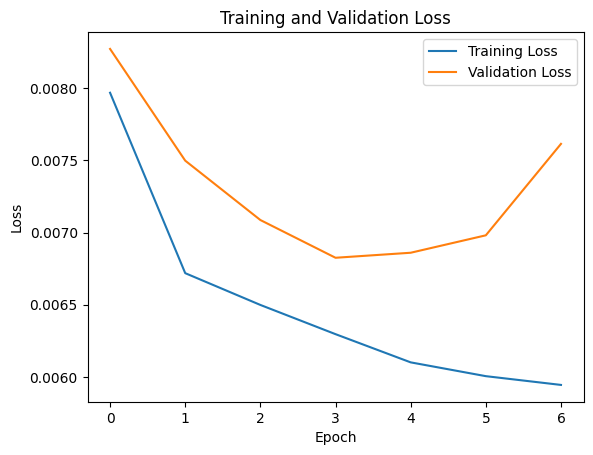

In [13]:
# Plot the training and validation loss 
Eval.Plot(History)

From this graph, it is evident that the model began exhibiting signs of overfitting, the Early Stopping criteria stopped the training process.

**CNN Model Training and Evaluation**

In [14]:
# Build CNN model
model_1 = Sequential()
model_1.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(24, X_train.shape[-1])))
model_1.add(MaxPooling1D(pool_size=2))
#model_1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_1.add(Flatten())
model_1.add(Dense(units=16, activation="relu"))
model_1.add(Dense(units=2))
# Compile the model
model_1.compile(optimizer='adam', loss=Huber(), metrics=["mse"])
# Train the model
History_1=model_1.fit(train_data, validation_data=valid_data, epochs=50, callbacks=[callback])

Epoch 1/50
614/614 [==============================] - 10s 11ms/step - loss: 0.0098 - mse: 0.0196 - val_loss: 0.0096 - val_mse: 0.0192
Epoch 2/50
614/614 [==============================] - 7s 11ms/step - loss: 0.0072 - mse: 0.0143 - val_loss: 0.0079 - val_mse: 0.0158
Epoch 3/50
614/614 [==============================] - 7s 11ms/step - loss: 0.0066 - mse: 0.0133 - val_loss: 0.0074 - val_mse: 0.0149
Epoch 4/50
614/614 [==============================] - 7s 12ms/step - loss: 0.0065 - mse: 0.0130 - val_loss: 0.0078 - val_mse: 0.0155
Epoch 5/50
614/614 [==============================] - 6s 11ms/step - loss: 0.0065 - mse: 0.0130 - val_loss: 0.0073 - val_mse: 0.0146
Epoch 6/50
614/614 [==============================] - 7s 11ms/step - loss: 0.0063 - mse: 0.0126 - val_loss: 0.0072 - val_mse: 0.0144
Epoch 7/50
614/614 [==============================] - 7s 11ms/step - loss: 0.0062 - mse: 0.0124 - val_loss: 0.0073 - val_mse: 0.0147
Epoch 8/50
614/614 [==============================] - 7s 11ms/step -

In [15]:
# Perform evaluation on training data and get False Positive Rate Dates
Training,M1_FPRD_training=Eval.Evaluation(model_1,train_data,X_train,X_train_surplus,24)
# Perform evaluation on validation data and get False Positive Rate Dates
Validation,M1_FPRD_validation=Eval.Evaluation(model_1,valid_data,X_val,X_val_surplus,24)
# Perform evaluation on test data and get False Positive Rate Dates
Testing,M1_FPRD_testing=Eval.Evaluation(model_1,test_data,test_df,test_surplus,24)
# Combine the evaluation results from training, validation, and testing
model1_evaluation=Eval.Full_Evaluation(Training,Validation,Testing)


192/192 [==============================] - 1s 6ms/step - loss: 0.0066 - mse: 0.0132
              Training     Value           Validation     Value  \
0                  MSE  0.012385                  MSE  0.013247   
1             Accuracy  0.851781             Accuracy  0.830273   
2            Precision  0.878291            Precision  0.843349   
3               Recall  0.643475               Recall  0.553557   
4  False Positive Rate  0.044429  False Positive Rate  0.045981   

               Testing     Value  
0                  MSE  0.013220  
1             Accuracy  0.842183  
2            Precision  0.808090  
3               Recall  0.618859  
4  False Positive Rate  0.062638  


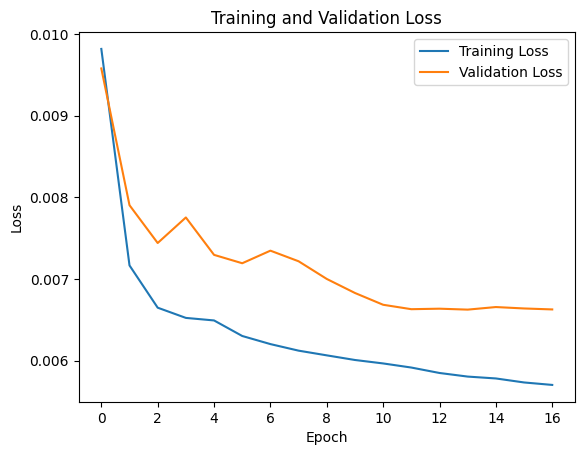

In [16]:
# Plot the training and validation loss 
Eval.Plot(History_1)

From the graph, Convolutional Neural Network (CNN) exhibited less overfitting compared to the LSTM model, consequently attaining a lower Mean Squared Error (MSE) score.

**CNN+LSTM Model Training and Evaluation**

In [17]:
# Build the model
model_2 = Sequential()
# Conv layer
model_2.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(24, X_train.shape[-1])))
model_2.add(MaxPooling1D(pool_size=2))
# LSTM layer
model_2.add(LSTM(16, return_sequences=True))
model_2.add(LSTM(8))
# Dense layers
model_2.add(Dense(8, activation='relu'))
model_2.add(Dense(2))
model_2.compile(optimizer='adam', loss=Huber(), metrics=["mse"])
# Train the model
History_2=model_2.fit(train_data, validation_data=valid_data, epochs=50, callbacks=[callback])

Epoch 1/50
614/614 [==============================] - 16s 19ms/step - loss: 0.0114 - mse: 0.0228 - val_loss: 0.0108 - val_mse: 0.0215
Epoch 2/50
614/614 [==============================] - 11s 19ms/step - loss: 0.0077 - mse: 0.0153 - val_loss: 0.0079 - val_mse: 0.0158
Epoch 3/50
614/614 [==============================] - 12s 19ms/step - loss: 0.0068 - mse: 0.0137 - val_loss: 0.0075 - val_mse: 0.0151
Epoch 4/50
614/614 [==============================] - 12s 19ms/step - loss: 0.0064 - mse: 0.0128 - val_loss: 0.0088 - val_mse: 0.0175
Epoch 5/50
614/614 [==============================] - 12s 19ms/step - loss: 0.0063 - mse: 0.0127 - val_loss: 0.0076 - val_mse: 0.0152
Epoch 6/50
614/614 [==============================] - 11s 19ms/step - loss: 0.0063 - mse: 0.0126 - val_loss: 0.0077 - val_mse: 0.0153


In [18]:
# Perform evaluation on training data
Training,M2_FPRD_training=Eval.Evaluation(model_2,train_data,X_train,X_train_surplus,24)
# Perform evaluation on validation data
Validation,M2_FPRD_validation=Eval.Evaluation(model_2,valid_data,X_val,X_val_surplus,24)
# Perform evaluation on test data
Testing,M2_FPRD_testing=Eval.Evaluation(model_2,test_data,test_df,test_surplus,24)
# Combine the evaluation results from training, validation, and testing
model2_evaluation=Eval.Full_Evaluation(Training,Validation,Testing)

192/192 [==============================] - 2s 10ms/step - loss: 0.0073 - mse: 0.0145
              Training     Value           Validation     Value  \
0                  MSE  0.016530                  MSE  0.015063   
1             Accuracy  0.822802             Accuracy  0.818441   
2            Precision  0.827775            Precision  0.803941   
3               Recall  0.589897               Recall  0.545470   
4  False Positive Rate  0.061152  False Positive Rate  0.059488   

               Testing     Value  
0                  MSE  0.014535  
1             Accuracy  0.835005  
2            Precision  0.778136  
3               Recall  0.626501  
4  False Positive Rate  0.076131  


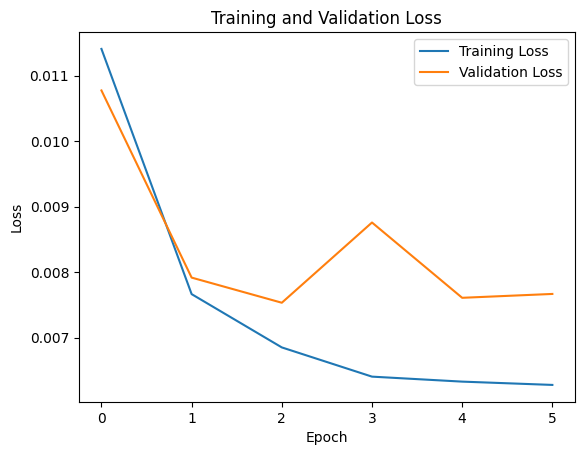

In [19]:
# Plot the training and validation loss 
Eval.Plot(History_2)

From the graph, it is apparent that the CNN LSTM model also exhibited overfitting similar to LSTM model, achieving a higher Mean Squared Error  than the CNN model.

# **Model Evaluation Analysis**

In [20]:
# Since the Mean Model had higher MSE it was neglected, the evaluation only been made to Deep Learning Model
# Concatenate the evaluation results from different models along the columns axis
combined_df = pd.concat([model_evaluation.iloc[0:,-1], model1_evaluation.iloc[0:,-1], model2_evaluation.iloc[0:,-1]], axis=1)
# Rename the columns to indicate the models
combined_df.columns = ["LSTM","CNN","CNN LSTM"]
# Set custom index labels to represent evaluation metrics
combined_df.index = ["MSE", 'Accuracy', 'Precision', 'Recall', 'False Positive Rate']

combined_df

,LSTM,CNN,CNN LSTM
MSE,0.013642,0.013220,0.014535
Accuracy,0.840470,0.842183,0.835005
Precision,0.774245,0.808090,0.778136
Recall,0.658024,0.618859,0.626501
False Positive Rate,0.081773,0.062638,0.076131


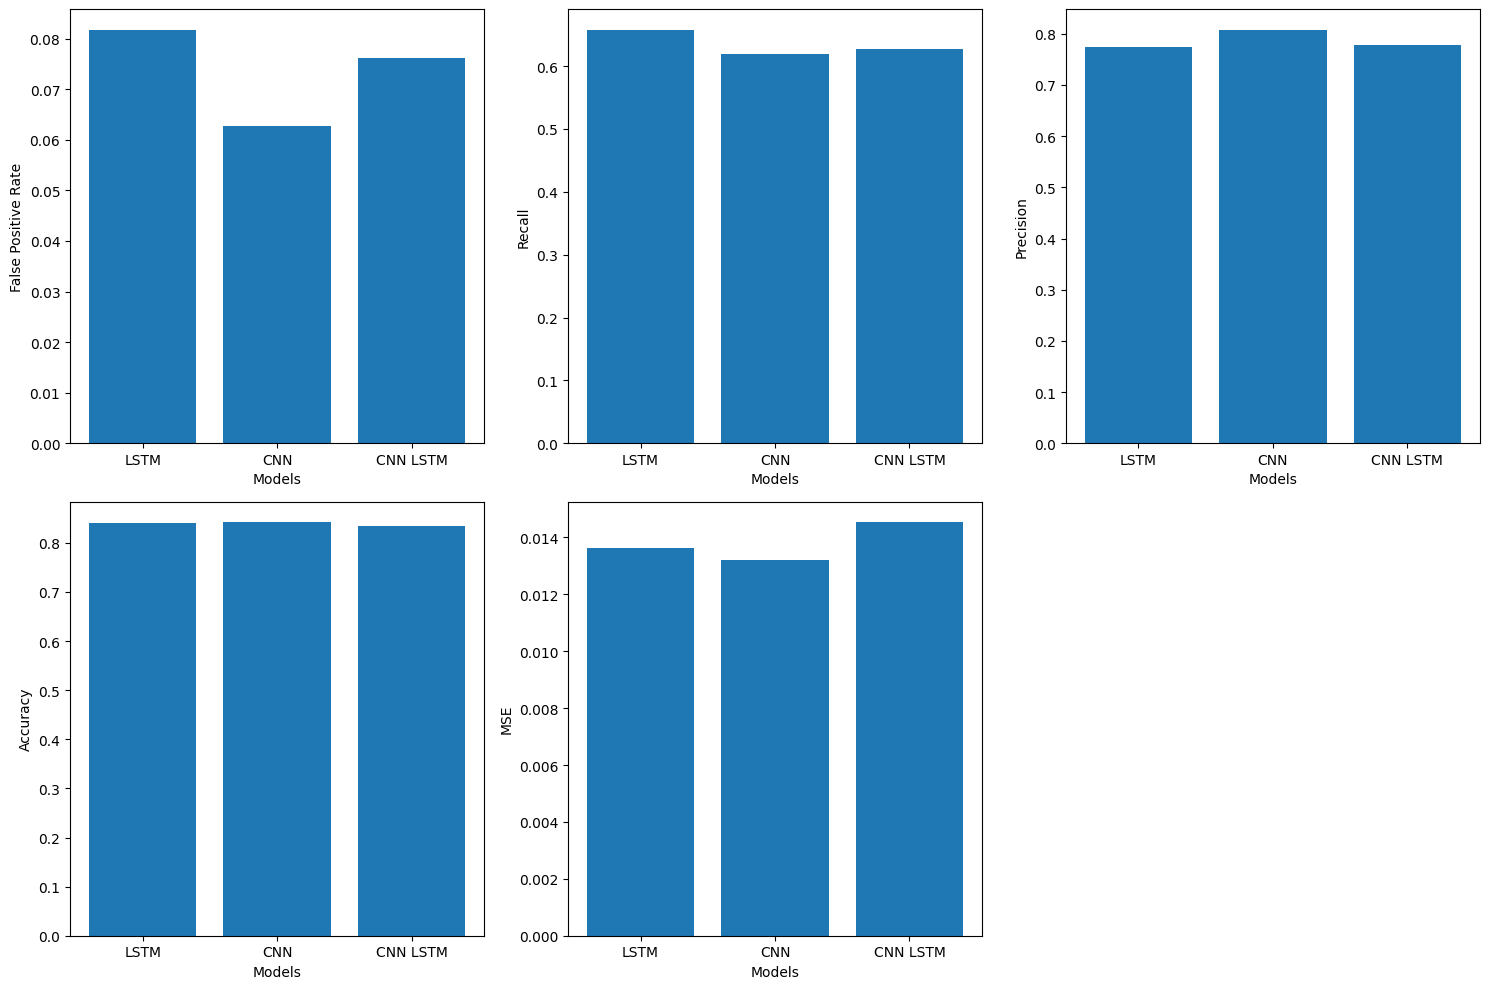

In [21]:
# Set the size of the entire figure
plt.figure(figsize=(15, 10))
# Subplot 1: False Positive Rate
plt.subplot(2, 3, 1)
plt.bar(combined_df.columns, combined_df.iloc[-1])
plt.xlabel("Models")
plt.ylabel("False Positive Rate")
# Subplot 2: Recall
plt.subplot(2, 3, 2)  
plt.bar(combined_df.columns, combined_df.iloc[-2])
plt.xlabel("Models")
plt.ylabel('Recall')
# Subplot 3: Precision
plt.subplot(2, 3, 3)
plt.bar(combined_df.columns, combined_df.iloc[-3])
plt.xlabel("Models")
plt.ylabel('Precision')
# Subplot 4: Accuracy
plt.subplot(2, 3, 4)
plt.bar(combined_df.columns, combined_df.iloc[-4])
plt.xlabel("Models")
plt.ylabel('Accuracy')
# Subplot 5: Mean Squared Error (MSE)
plt.subplot(2, 3, 5)
plt.bar(combined_df.columns, combined_df.iloc[-5])
plt.xlabel("Models")
plt.ylabel('MSE')  

plt.tight_layout()  
plt.show()

From the above graph and table:
- CNN model attained the lowest Mean Squared Error (MSE) of 0.013220 and an impressively low False Positive Rate of 6.2%. In addition, CNN model exhibited remarkable accuracy and precision of 84.2% and 80.80% respectively, outperforming the other models in these metrics.
- LSTM model excelled in the Recall metric, achieving the highest score of 65.8%.


In [22]:
def plot_prediciton(model,test_data,y_test_scaled ,test_df,sequance_lenth,name,Hours=0):
    """
    Plot predictions and actual values. eithar all data using moving average or  last certain hours

    Parameters:
    - model ==> Trained model for prediction
    - test_data ==> Test data for prediction
    - y_test_scaled ==> Scaled test target values
    - test_df ==> Test DataFrame containing additional data
    - Hours: Number of hours for which to plot data (default: 0)
    if Hours is zero model will plot prediction using Movinge Average 
    else the user will determine the number of hours 
    """
    # Get Prediction and put them in DataFrame 
    prediction = pd.DataFrame(model.predict(test_data),columns=["predicted_windspeed","predicted_solarenergy"])
    # put the y_test in DataFrame 
    y_test = pd.DataFrame(y_test_scaled[24+sequance_lenth-1:],columns=["windspeed","solarenergy"])
    #  Concatenate predictions and y_test along the columns axis
    con = pd.concat([prediction,y_test],axis=1)
    # Set index of concatenated DataFrame to match test_df (For Dates)
    con.index = test_df[24+sequance_lenth-1:].index
    # Create a copy of the concatenated DataFrame
    df_= con.copy()
    
    # Plot predictions and actual values
    if Hours:
        # Plot only for specified number of hours
        df_[-Hours:].plot(figsize=(15, 10))
        plt.title(name)
    else:
        # Calculate moving averages and plot for the entire data
        df_['MA_predicted_windspeed'] = df_['predicted_windspeed'].rolling(window=3*24).mean()
        df_['MA_predicted_solarenergy'] = df_['predicted_solarenergy'].rolling(window=3*24).mean()
        df_['MA_windspeed'] = df_['windspeed'].rolling(window=3*24).mean()
        df_['MA_solarenergy'] = df_['solarenergy'].rolling(window=3*24).mean()
        # Plot MA data
        df_.iloc[0:,4:].plot(figsize=(25,9))
        plt.xlabel("Date")
        plt.ylabel("Values")
        plt.title(name)
        plt.legend()
        
    

192/192 [==============================] - 2s 10ms/step


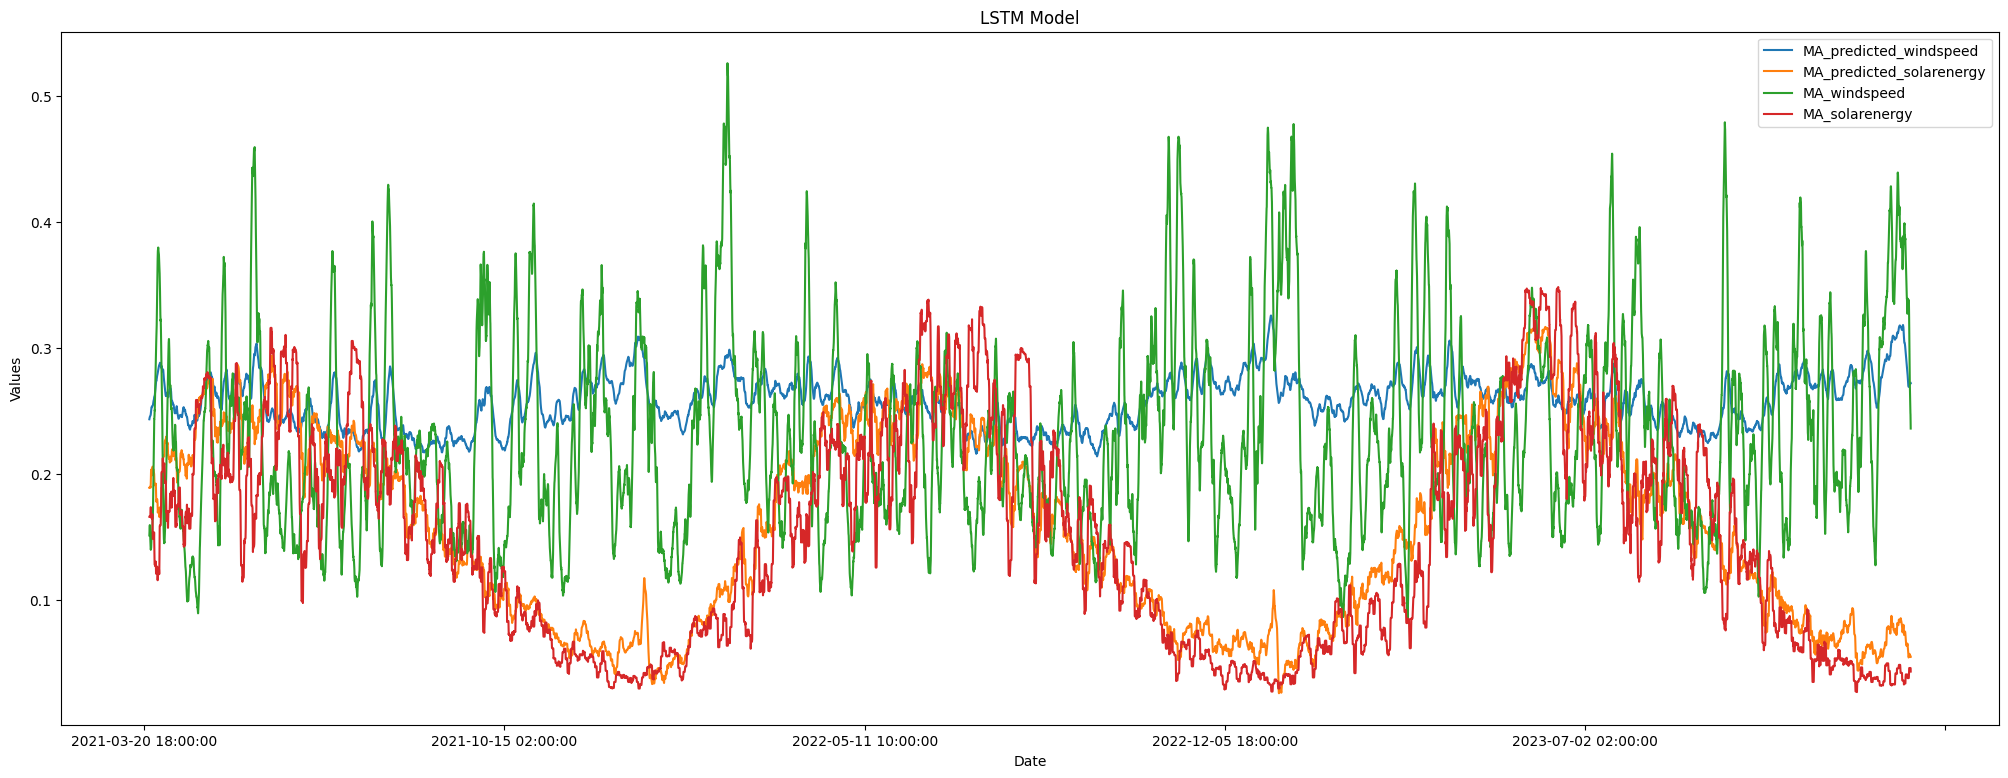

In [23]:
plot_prediciton(model,test_data,y_test_scaled,test_df,24,"LSTM Model")

192/192 [==============================] - 1s 5ms/step


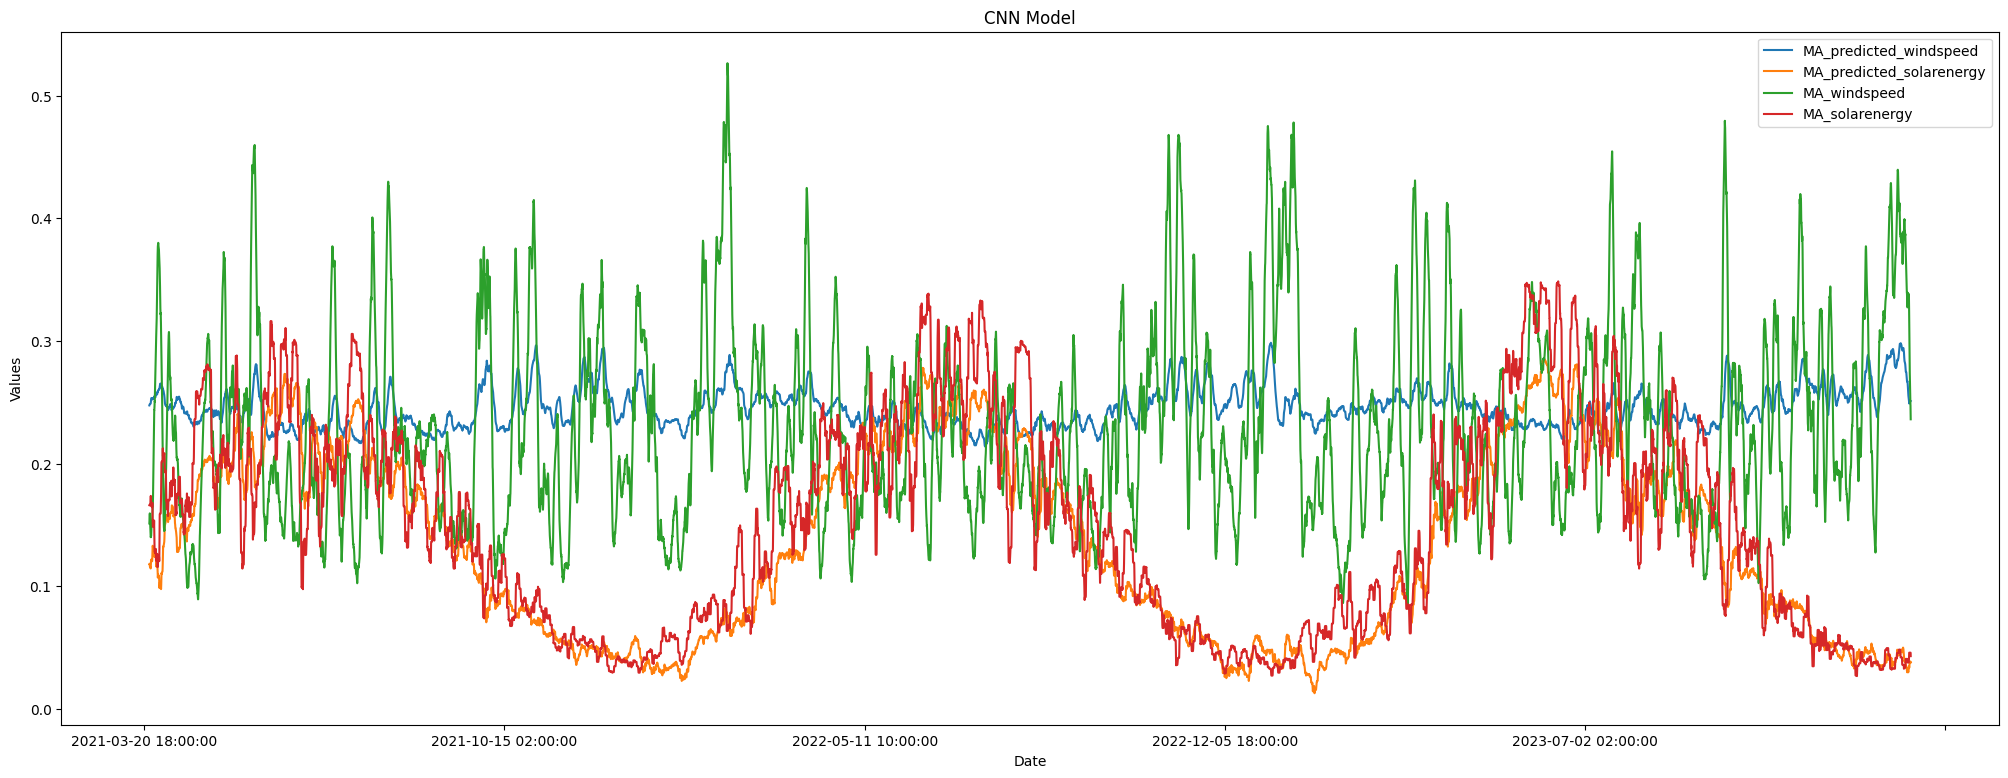

In [24]:
plot_prediciton(model_1,test_data,y_test_scaled,test_df,24,"CNN Model")

192/192 [==============================] - 1s 7ms/step


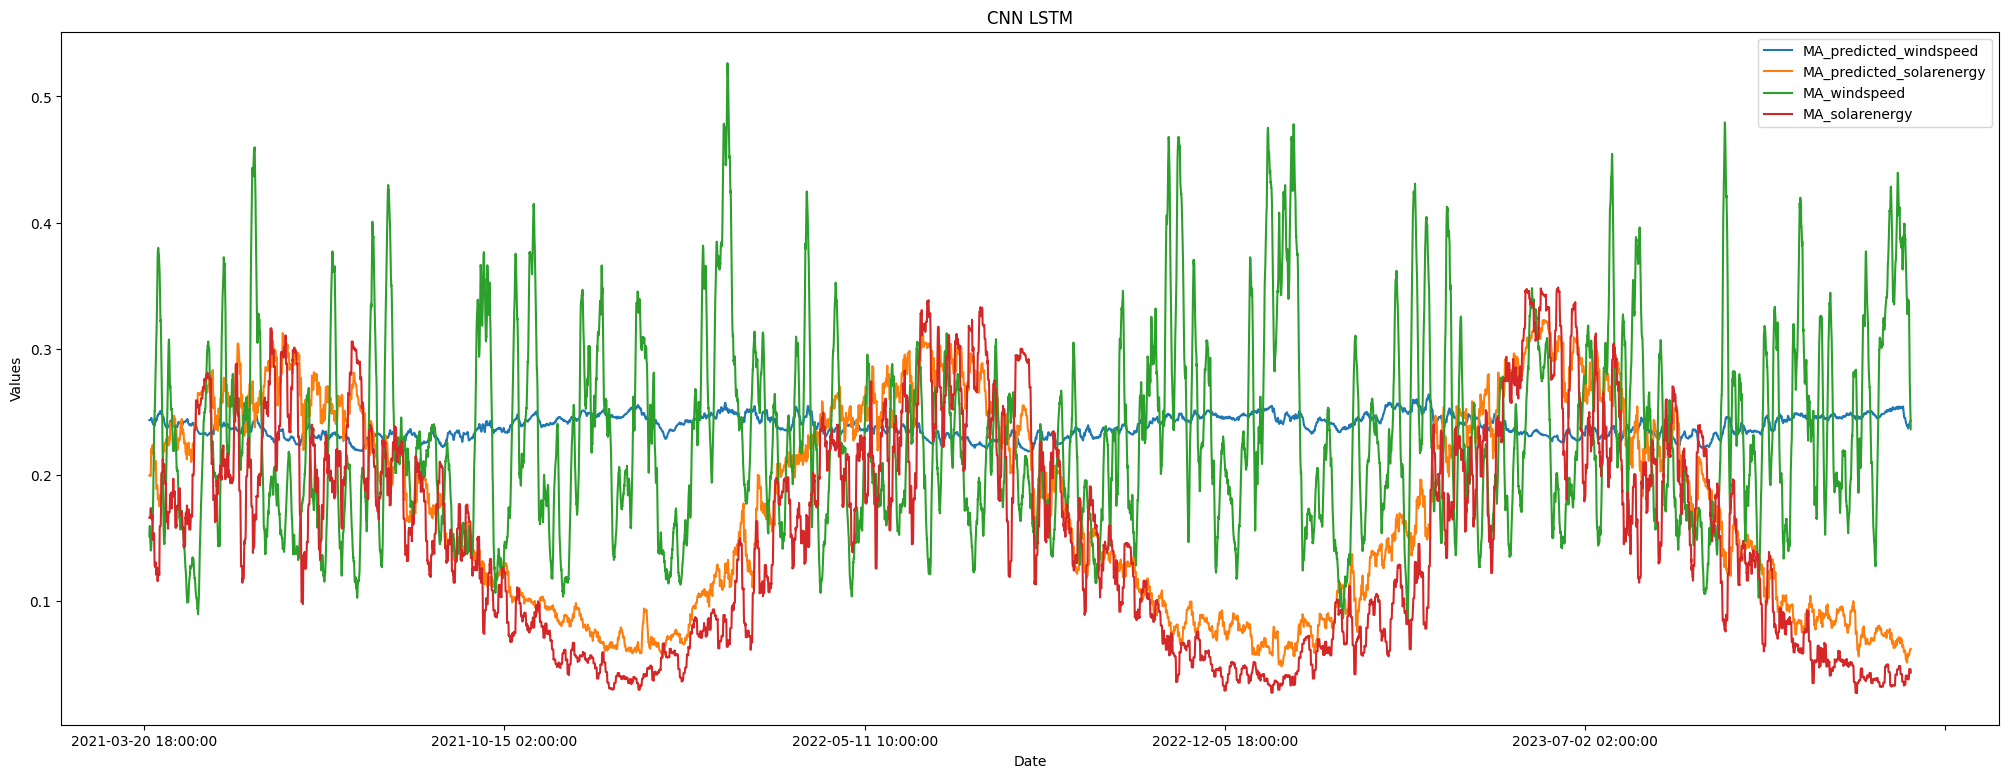

In [25]:
plot_prediciton(model_2,test_data,y_test_scaled,test_df,24,"CNN LSTM")

From the above Graphs : 
- We can see that the models excel in forecasting solar energy, but they consistently struggle to accurately predict wind speed.

192/192 [==============================] - 1s 6ms/step


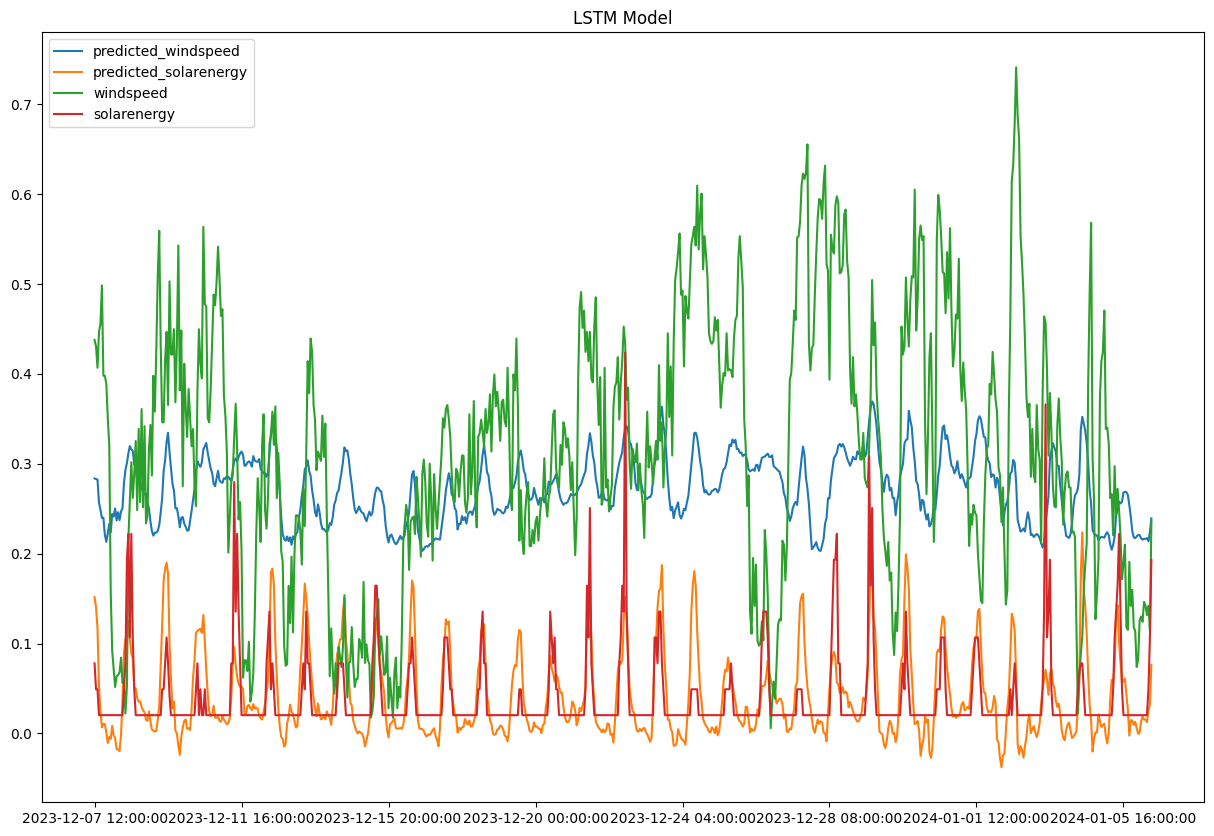

In [26]:
# Plot the Data For one month
plot_prediciton(model_1,test_data,y_test_scaled,test_df,24,"LSTM Model",720)

192/192 [==============================] - 1s 6ms/step


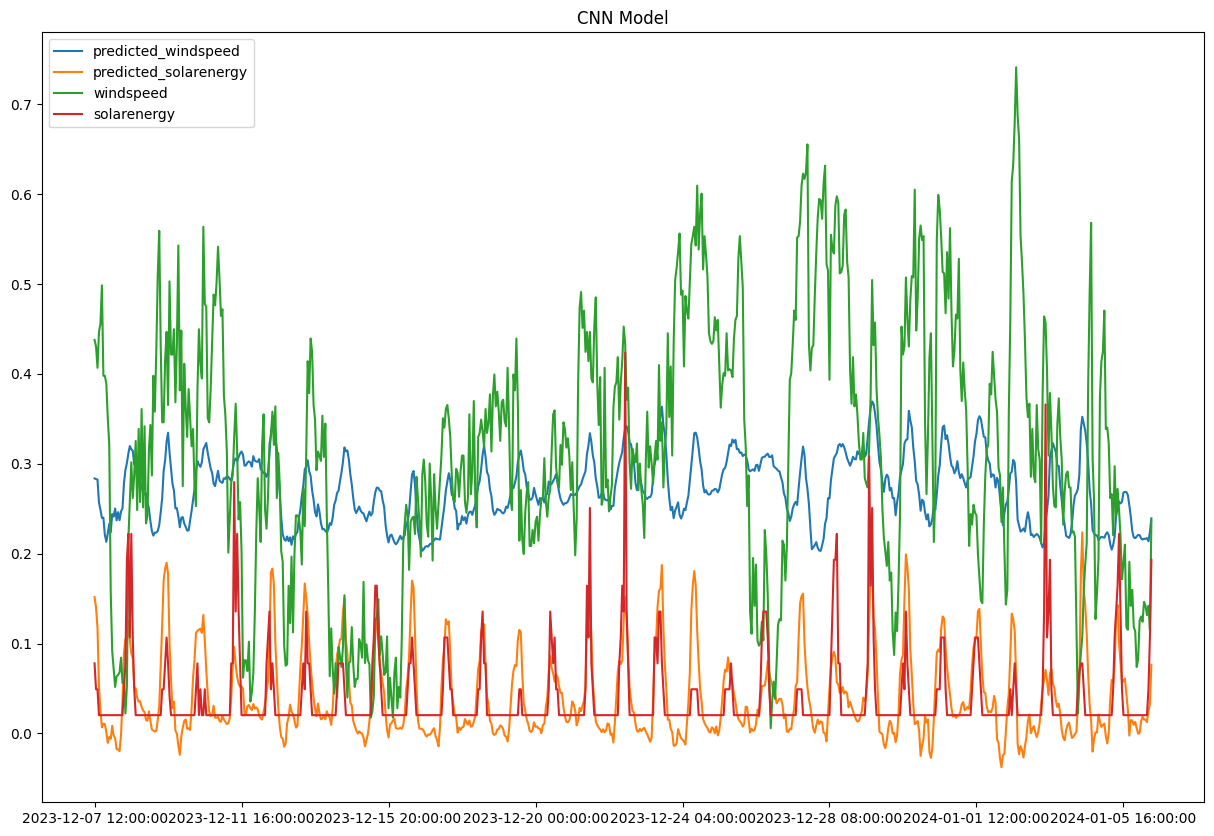

In [27]:
# Plot the Data For one month
plot_prediciton(model_1,test_data,y_test_scaled,test_df,24,"CNN Model",720)

192/192 [==============================] - 1s 7ms/step


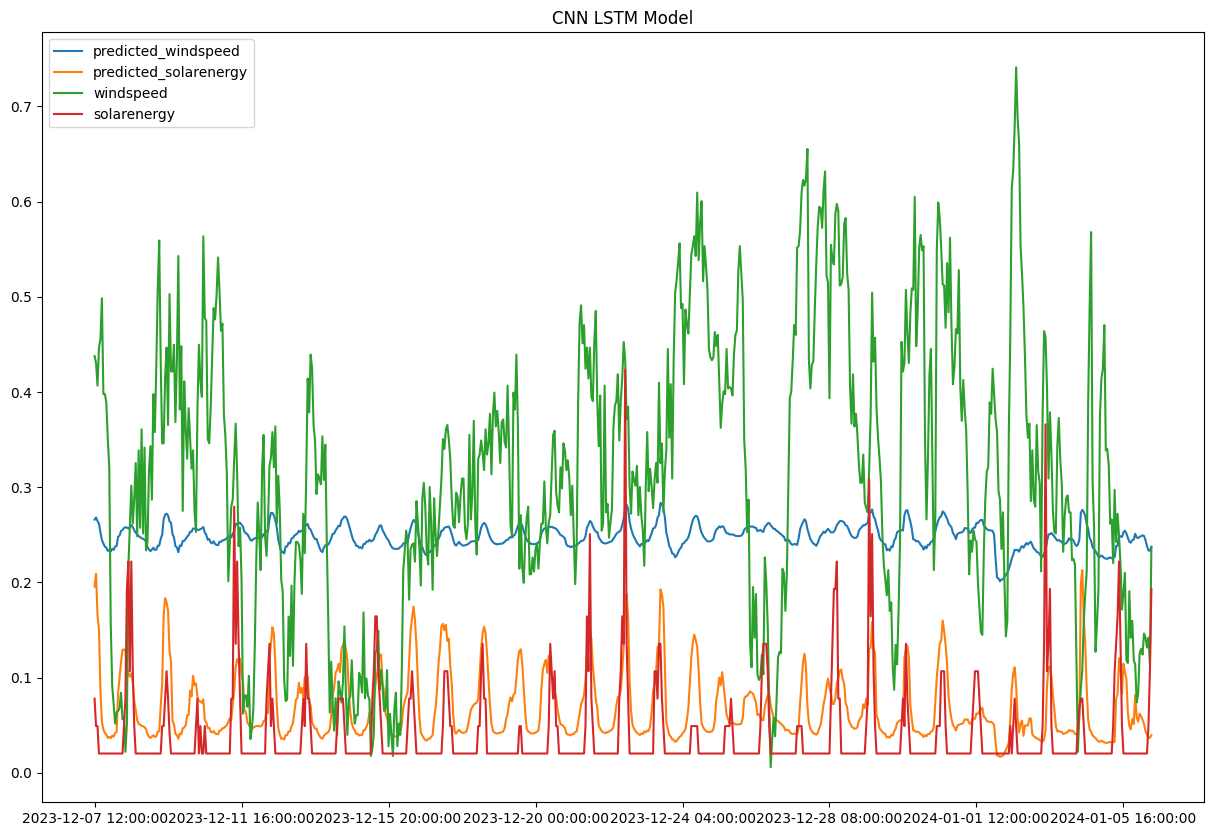

In [28]:
# Plot the Data For one month
plot_prediciton(model_2,test_data,y_test_scaled,test_df,24,"CNN LSTM Model",720)

The preceding graphs illustrates monthly predictions, confirming that all models effectively forecast solar energy, while encountering challenges in accurately predicting wind speed.

# **False Positive Analysis**

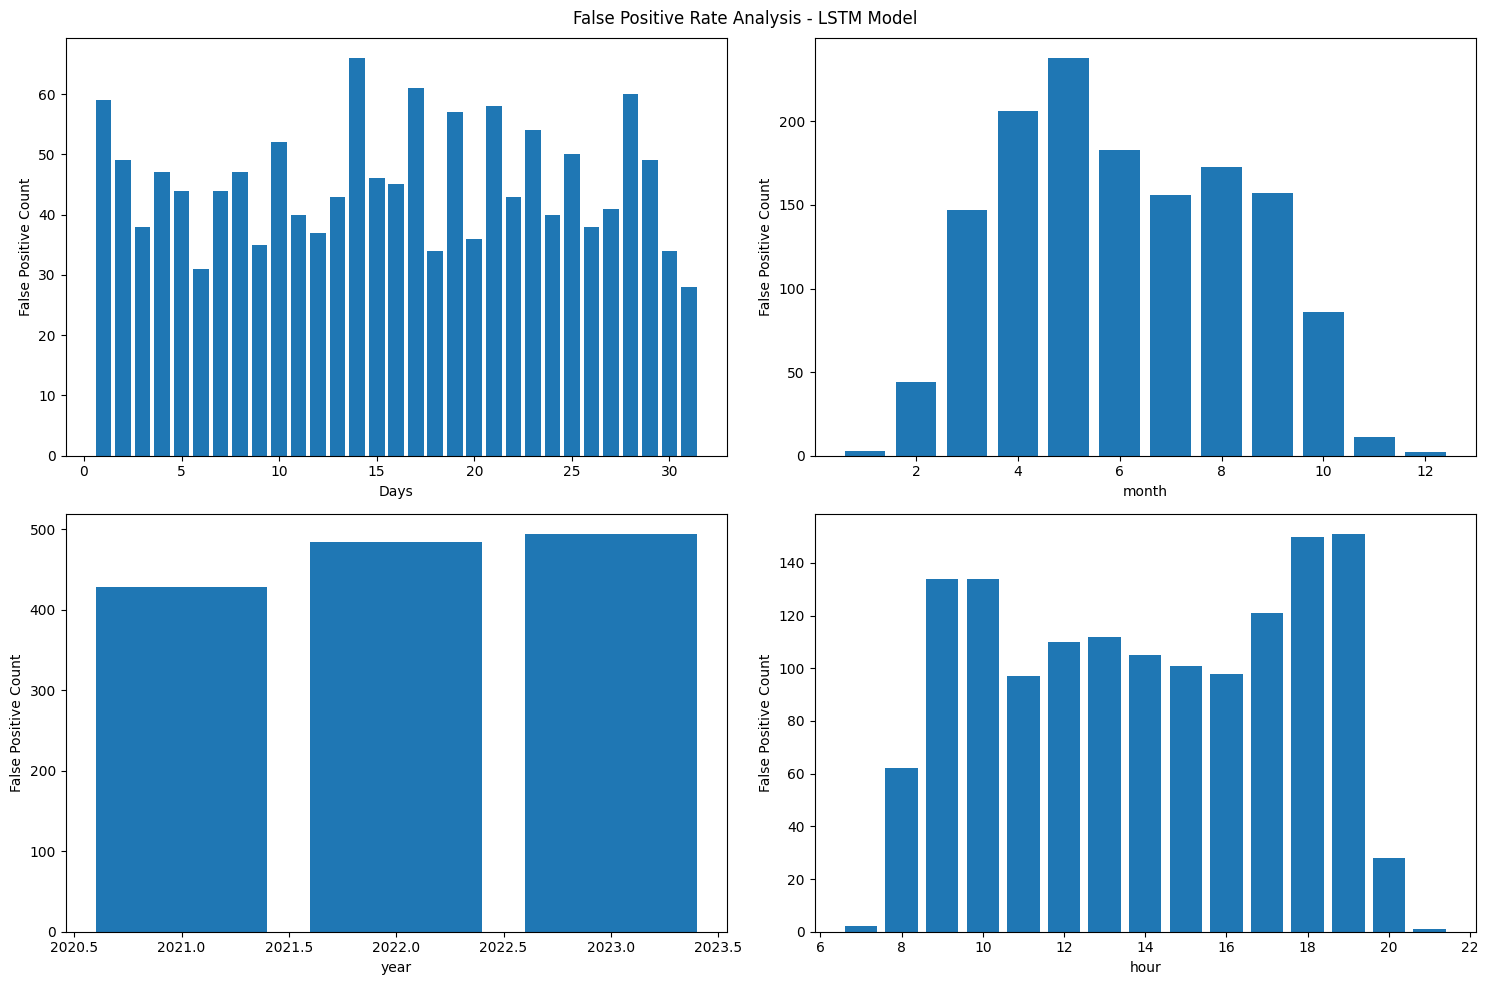

Top 3 most frequent days: [14, 17, 28]
Top 3 most frequent months: [5, 4, 6]
Top 3 most frequent years: [2023, 2022, 2021]
Top 3 most frequent hours: [19, 18, 10]


In [29]:
# Plot the False Positive Rate Analysis 
Eval.False_Positive_Rate_Anaylsis(M_FPRD_testing,model_name="LSTM Model")

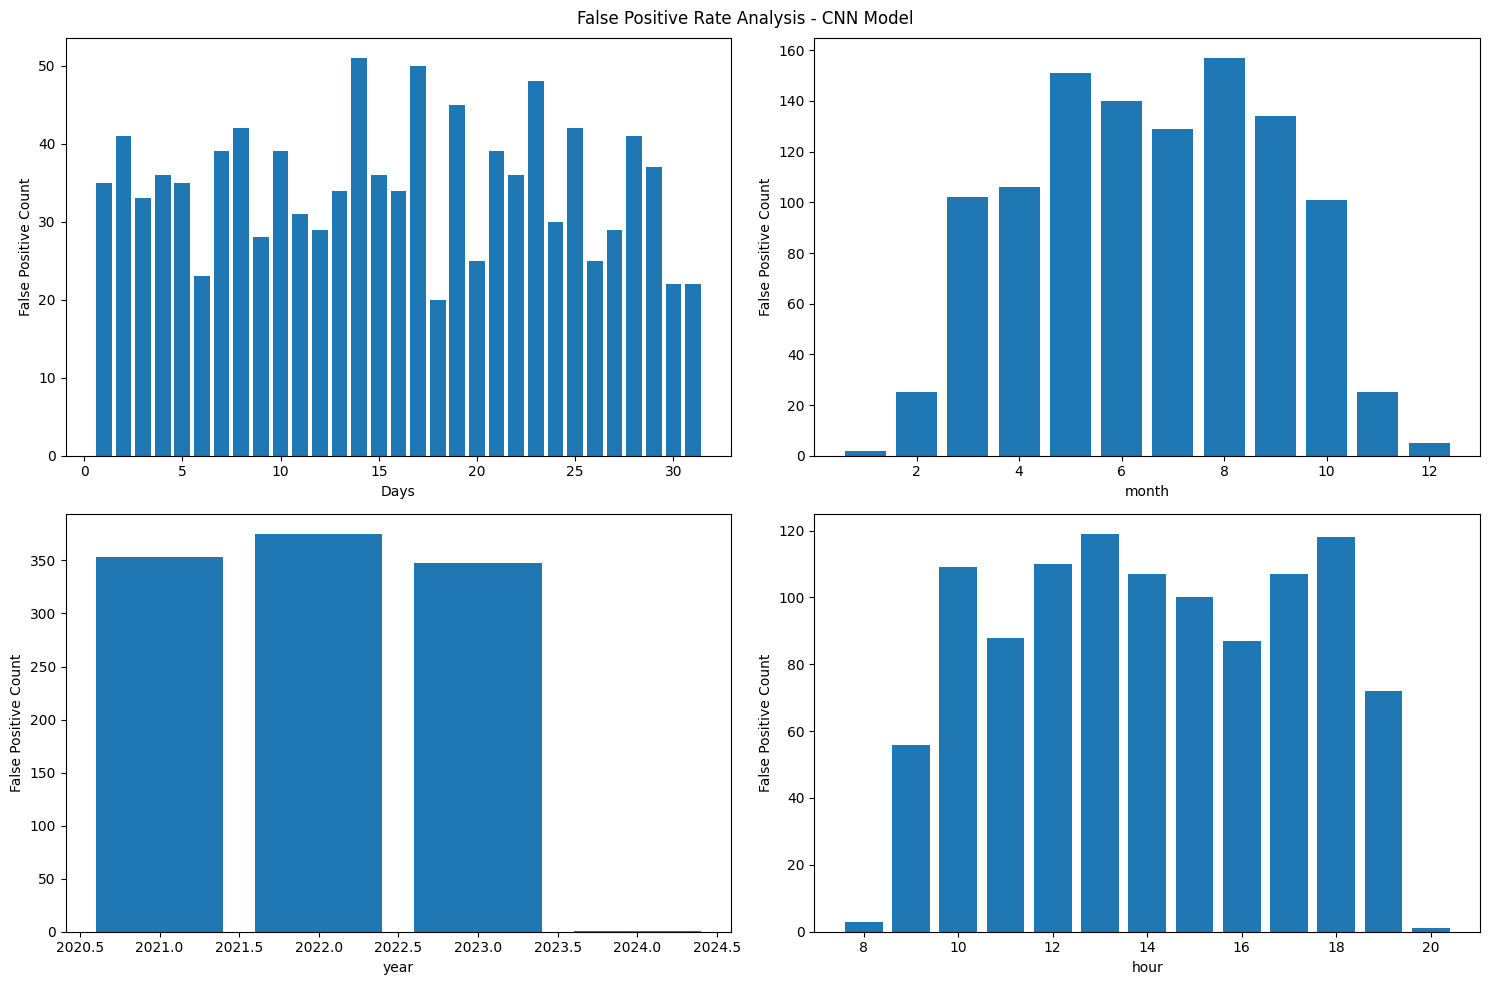

Top 3 most frequent days: [14, 17, 23]
Top 3 most frequent months: [8, 5, 6]
Top 3 most frequent years: [2022, 2021, 2023]
Top 3 most frequent hours: [13, 18, 12]


In [30]:
# Plot the False Positive Rate Analysis 
Eval.False_Positive_Rate_Anaylsis(M1_FPRD_testing,model_name="CNN Model")

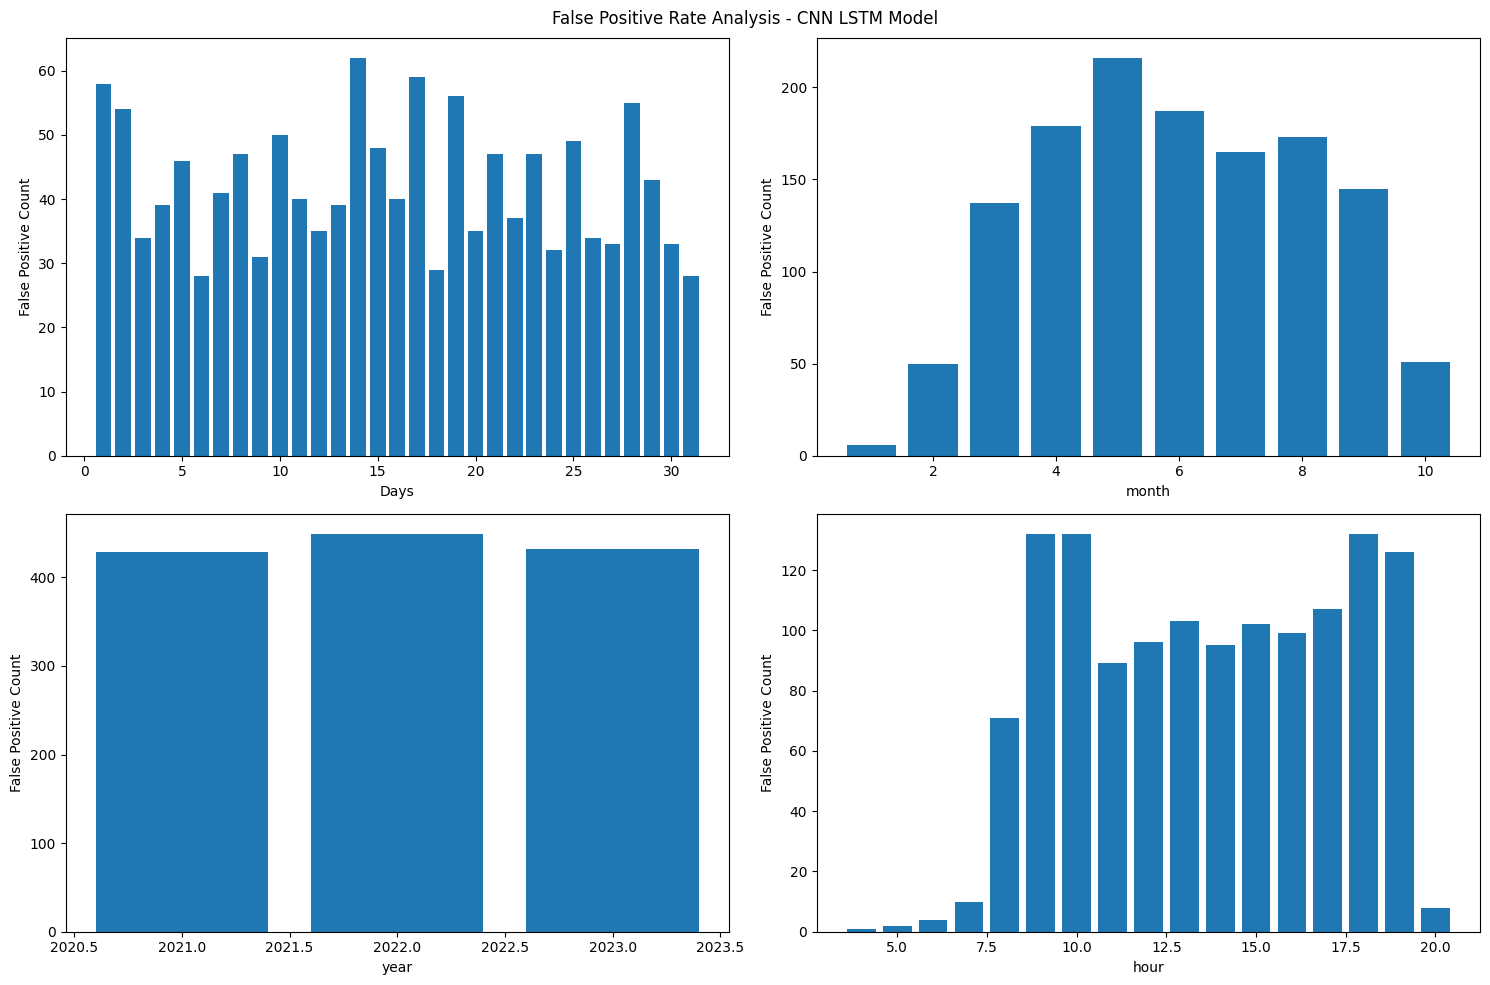

Top 3 most frequent days: [14, 17, 1]
Top 3 most frequent months: [5, 6, 4]
Top 3 most frequent years: [2022, 2023, 2021]
Top 3 most frequent hours: [10, 9, 18]


In [31]:
# Plot the False Positive Rate Analysis 
Eval.False_Positive_Rate_Anaylsis(M2_FPRD_testing,model_name="CNN LSTM Model")

From Above Graphs 
- We can observe that all models exhibited high false positive predictions on the {14th and 17th} days.
- The models showed elevated false positive predictions between {April - August}.
- There is a uniform distribution among the three models in false positive prediction.
- We notice that the models also had high positive predictions between {10 am - 6 pm}.

# **Model Selection and Saving the best model**

According to the analysis in the previous section, the CNN (Convolutional Neural Network) emerged as the best model for False Positive Rate, Accuracy, MSE, and Precision. As a result, it will be used going forward.

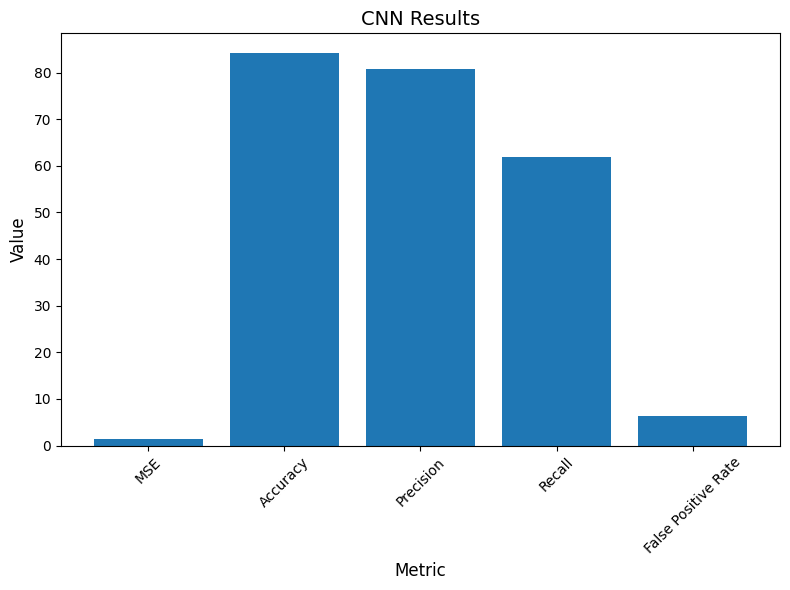

In [32]:
# assign variable for the CNN metrics
cnn_data = combined_df.loc[:,'CNN']*100

# Create a bar chart
metric_names = cnn_data.index
metric_values = cnn_data.values

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(metric_names, metric_values)
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('CNN Results', fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

This Graph shows the Evaluation Resultls for CNN Model

In [33]:
# Save The model 
model_1.save('my_model')

# **Framework Evaluation**

**In this section**, we will evaluate the framework from the company's perspective. from the previous section, the most important metric is the false positive rate, as it costs the company money to provide free energy when it should not.bThe false positive rate for the model, according to the previous section is 7.1%. 

the hourly consumption for the whole city of Brighton is 0.24 GWh for the months of January, February, March, October, November, and December, and 0.16 GWh for the remaining months. The cost per kWh in the UK is 0.245 pound .

To calculate the company's losses, we first determine the hourly loss by multiplying the hourly consumption (in kWh) by the cost per kWh in the UK:


$ Hourly Loss = Hourly Consumption (kWh) × Cost/kWh $

Next, we calculate the total loss by multiplying the hourly loss by the number of hours that were falsely classified as positive:

$Total loss = Hourly Loss × Number of Hours Falsely Classified as Positive$

We already have the hours which were misclassified from the False Positive Dates DataFrame, and we will utilize it in our calculations.


In [34]:
#Calculate the Hourly Loss
M1_FPRD_testing['Hourly Loss'] = np.where(M1_FPRD_testing['month'].isin([1, 2, 3, 10, 11, 12]),(240*10**3)*0.245,(160*10**3)*0.245)

In [35]:
#Hour loss 
M1_FPRD_testing['Hourly Loss'].value_counts()

Hourly Loss
39200.0    817
58800.0    260
Name: count, dtype: int64

In [36]:
# Total loss for false positive 
total_loss = sum(M1_FPRD_testing["Hourly Loss"])
total_loss

47314400.0

From the previous cells, the hourly loss in the months of January, February, March, October, November, and December is £58,000 per hour, and £39,200 for the remaining months. For all the misclassified hours, making the total loss £47,314,400.

# **Notable Assumptions**

- Most of the assumptions that have been made in this project were stated in the Data Exploration Notebook and will be documented in the README file. 

- End-users are divided into residential and industrial loads. If there's a surplus forecasted, users may increase consumption during that time, risking grid overload. To mitigate this, we allocate the surplus: 70% to residential users and 30% to industrial users. During the surplus period, each residential user gets a certain amount of free electricity, with extra charges for overconsumption. This strategy helps save costs for the company and reduces the risk of grid faults.


# **Conclusion**

- The system demonstrated high accuracy, precision, and recall while achieving low Mean Squared Error (MSE) and False Positive Rate (FPR) in predicting power surplus.

- The model is effective at predicting solar power, but it encounters significant challenges when it comes to predicting wind power, as indicated in the index figure.

- The model is not yet ready for deployment by May 2024, as improvements are needed to boost accuracy and reduce the False Positive Rate to high financial loss.

- We recommend deploying the model in the first and last quarters of the year when the False Positive Rate is lower. This provides an opportunity to collect data on consumer behaviour and monitor system performance.

- Use this period to assess market trends and evaluate the potential revenue from new users who choose this system as their energy provider due to the free surplus of electricity.
